Importing all important libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

Loading data

In [9]:
train_data = 'datasets/train/train_emoticon.csv'
test_data='datasets/test/test_emoticon.csv'
val_data='datasets/valid/valid_emoticon.csv'
df_train = pd.read_csv(train_data)
df_test = pd.read_csv(test_data)
df_val= pd.read_csv(val_data)
df_train.head()

,input_emoticon,label
0,😛🛐😻😑😣🙠🙯🚼😒🙼😑🙯😣,0
1,🛐😑😪😛🚼🙯😣🚅😑🙯😹😣🙼,0
2,😛🙯😑🚡😣🚼🛐🙲😣🙯🛑😑🙼,0
3,😛🚼🛐🙐😣🙯😑🙪😑🙼🛆😣🙯,1
4,🛐🚟🚼😛🙋😑😣🙯😹🙯😑😣🙼,1


In [10]:
percentages = list(range(5, 105, 5))

Function to split emojis and remove empty strings

In [11]:
def split_emojis(df):
    df_split = df['input_emoticon'].apply(lambda x: pd.Series(list(x)))
    df_split = df_split.replace('', pd.NA).dropna(axis=1, how='all')
    return df_split

In [12]:
train_emojis = split_emojis(df_train)
test_emojis = split_emojis(df_test)
val_emojis = split_emojis(df_val)

Applied One-Hot encoding to all three training, validation and test dataset

In [13]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

train_encoded = encoder.fit_transform(train_emojis)
test_encoded = encoder.transform(test_emojis)
val_encoded = encoder.transform(val_emojis)

train_encoded_df = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out())
test_encoded_df = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out())
val_encoded_df = pd.DataFrame(val_encoded, columns=encoder.get_feature_names_out())

df_encoded2 = pd.concat([df_train, train_encoded_df], axis=1)
df_test_enc = pd.concat([df_test, test_encoded_df], axis=1)
df_val_enc = pd.concat([df_val, val_encoded_df], axis=1)

Prepared data to apply models

In [14]:
x_train = df_encoded2.drop(columns=['input_emoticon', 'label'])
y_train = df_encoded2['label']
x_val = df_val_enc.drop(columns=['input_emoticon','label'])
y_val = df_val_enc['label']
x_test=df_test_enc.drop(columns=['input_emoticon'])

Function to train and validating different models

In [15]:
def train_validate_model(model, X_train, y_train):
  results_list = []

  for percentage in percentages:
      num_samples = int((percentage / 100) * len(X_train))
      X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=num_samples, random_state=42)
      model.fit(X_train_sample, y_train_sample)
      y_val_pred = model.predict(x_val)
      report = classification_report(y_val, y_val_pred, output_dict=True)
      accuracy = accuracy_score(y_val, y_val_pred)

      results_list.append({
        'Percentage of Training Data': percentage,
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
      })

  return pd.DataFrame(results_list)

Function to plot scores of different models 

In [16]:
def plot_results(model,results):
  plt.figure(figsize=(15, 5))
  plt.plot(results['Percentage of Training Data'], results['Accuracy'], marker='o', label='Accuracy')
  plt.plot(results['Percentage of Training Data'], results['Precision'], marker='o', label='Precision')
  plt.plot(results['Percentage of Training Data'], results['Recall'], marker='o', label='Recall')
  plt.plot(results['Percentage of Training Data'], results['F1-Score'], marker='o', label='F1-Score')
  plt.title(model+' Performance Metrics')
  plt.xlabel('Percentage of Training Data')
  plt.ylabel('Score')
  plt.xticks(results['Percentage of Training Data'])
  plt.legend()
  plt.grid()
  plt.show()

Logistic Regression

In [17]:
lr_model=LogisticRegression()
lr_result=train_validate_model(lr_model, x_train, y_train)
print(lr_result)

c:\Users\shiva\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


    Percentage of Training Data  Accuracy  Precision    Recall  F1-Score
0                             5  0.537832   0.546208  0.537832  0.529269
1                            10  0.627812   0.628680  0.627812  0.627868
2                            15  0.666667   0.666817  0.666667  0.666717
3                            20  0.707566   0.707708  0.707566  0.707611
4                            25  0.723926   0.724352  0.723926  0.723991
5                            30  0.756646   0.756831  0.756646  0.756354
6                            35  0.766871   0.767552  0.766871  0.766386
7                            40  0.787321   0.787416  0.787321  0.787157
8                            45  0.779141   0.779332  0.779141  0.778910
9                            50  0.793456   0.793767  0.793456  0.793208
10                           55  0.807771   0.807840  0.807771  0.807792
11                           60  0.824131   0.824108  0.824131  0.824106
12                           65  0.828221   0.82820

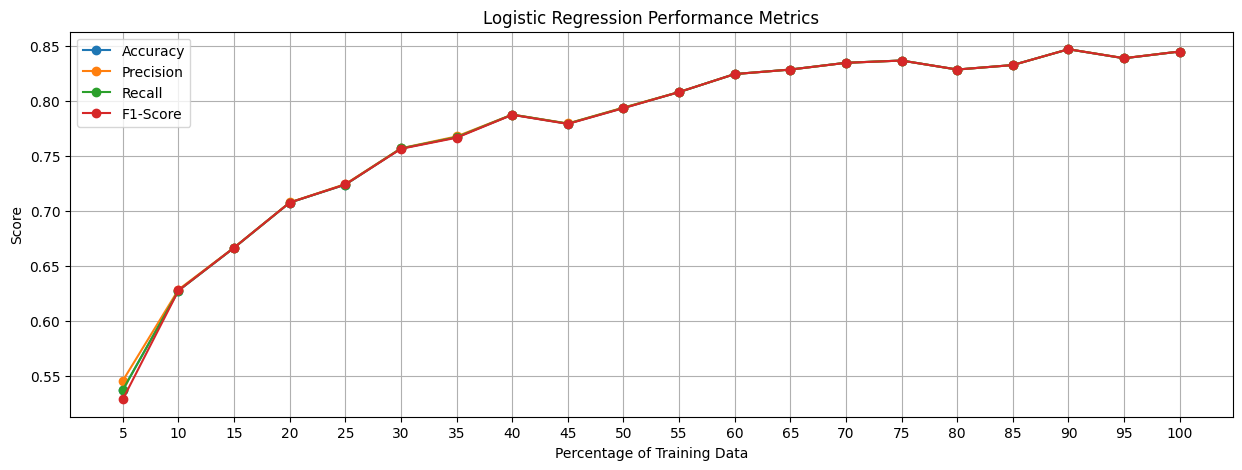

In [18]:
plot_results('Logistic Regression',lr_result)

Decision Tree Classifier

In [19]:
dtc_model = DecisionTreeClassifier(random_state=42)
dtc_result = train_validate_model(dtc_model, x_train, y_train)
print(dtc_result)

    Percentage of Training Data  Accuracy  Precision    Recall  F1-Score
0                             5  0.482618   0.485091  0.482618  0.479349
1                            10  0.496933   0.498425  0.496933  0.496478
2                            15  0.509202   0.511205  0.509202  0.508278
3                            20  0.529652   0.536983  0.529652  0.521469
4                            25  0.570552   0.578395  0.570552  0.565662
5                            30  0.572597   0.575194  0.572597  0.571871
6                            35  0.546012   0.551228  0.546012  0.542338
7                            40  0.552147   0.553533  0.552147  0.552005
8                            45  0.631902   0.632982  0.631902  0.631923
9                            50  0.572597   0.572137  0.572597  0.569738
10                           55  0.521472   0.519959  0.521472  0.518748
11                           60  0.660532   0.668367  0.660532  0.658499
12                           65  0.668712   0.67510

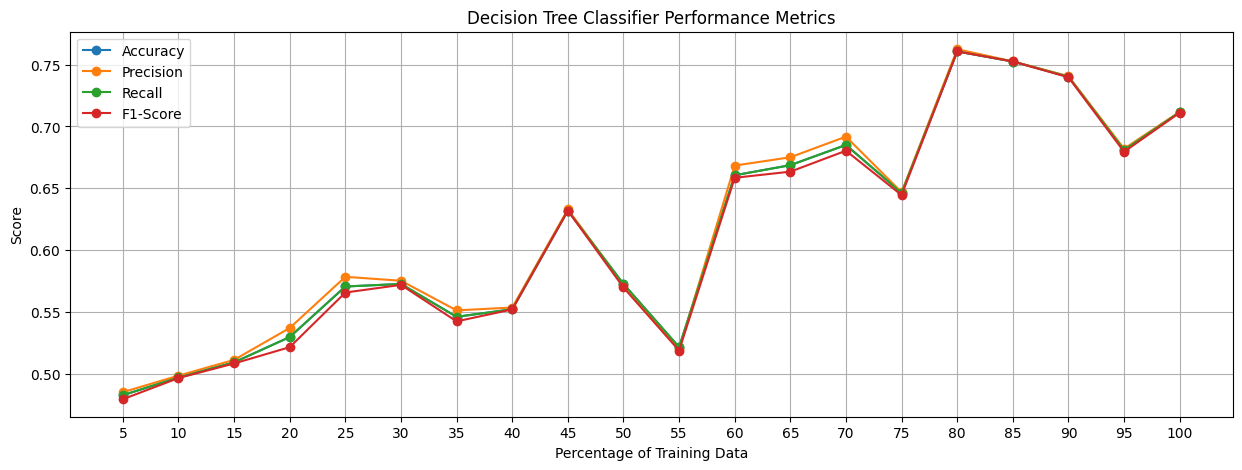

In [20]:
plot_results('Decision Tree Classifier',dtc_result)

Random Forest Classifier

In [21]:
rfc_model = RandomForestClassifier()
rfc_result = train_validate_model(rfc_model, x_train, y_train)
print(rfc_result)

    Percentage of Training Data  Accuracy  Precision    Recall  F1-Score
0                             5  0.503067   0.528272  0.503067  0.434329
1                            10  0.554192   0.553523  0.554192  0.553264
2                            15  0.552147   0.551664  0.552147  0.544786
3                            20  0.607362   0.609232  0.607362  0.602313
4                            25  0.607362   0.610169  0.607362  0.606764
5                            30  0.644172   0.645241  0.644172  0.641913
6                            35  0.640082   0.647417  0.640082  0.632268
7                            40  0.654397   0.661955  0.654397  0.647530
8                            45  0.697342   0.699565  0.697342  0.695420
9                            50  0.691207   0.697314  0.691207  0.687086
10                           55  0.666667   0.666515  0.666667  0.666365
11                           60  0.685072   0.687028  0.685072  0.683072
12                           65  0.713701   0.71715

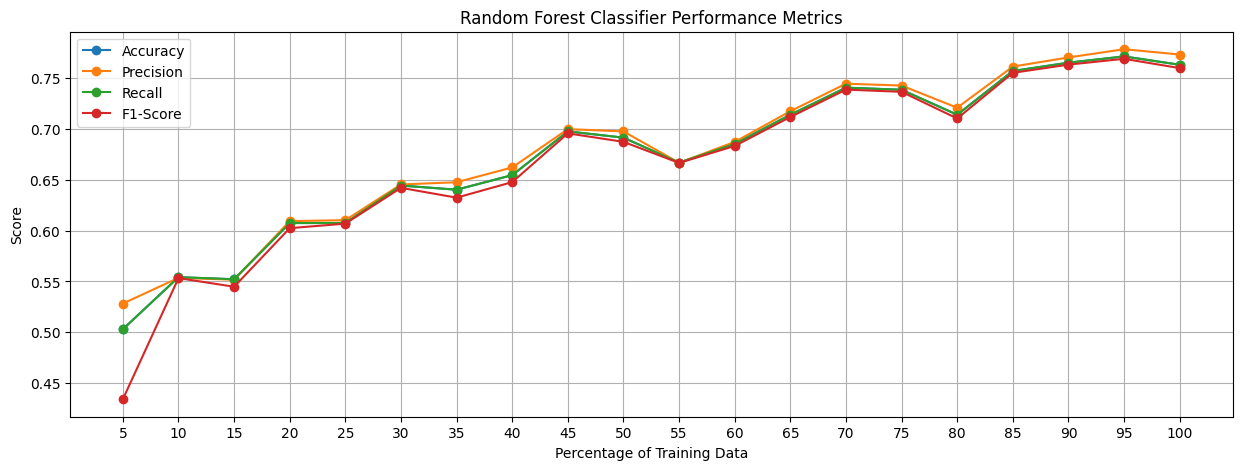

In [22]:
plot_results('Random Forest Classifier',rfc_result)

XG Boost Classifier

In [23]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_result = train_validate_model(xgb_model, x_train, y_train)
print(xgb_result)

c:\Users\shiva\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [22:34:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\shiva\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [22:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\shiva\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [22:34:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

    Percentage of Training Data  Accuracy  Precision    Recall  F1-Score
0                             5  0.466258   0.468226  0.466258  0.455428
1                            10  0.521472   0.522109  0.521472  0.521572
2                            15  0.539877   0.540741  0.539877  0.539927
3                            20  0.562372   0.562609  0.562372  0.562453
4                            25  0.586912   0.589256  0.586912  0.586418
5                            30  0.629857   0.629607  0.629857  0.629413
6                            35  0.601227   0.600862  0.601227  0.600316
7                            40  0.650307   0.652343  0.650307  0.650122
8                            45  0.695297   0.697657  0.695297  0.693258
9                            50  0.703476   0.703569  0.703476  0.703024
10                           55  0.693252   0.693252  0.693252  0.693252
11                           60  0.705521   0.705975  0.705521  0.704787
12                           65  0.736196   0.73861

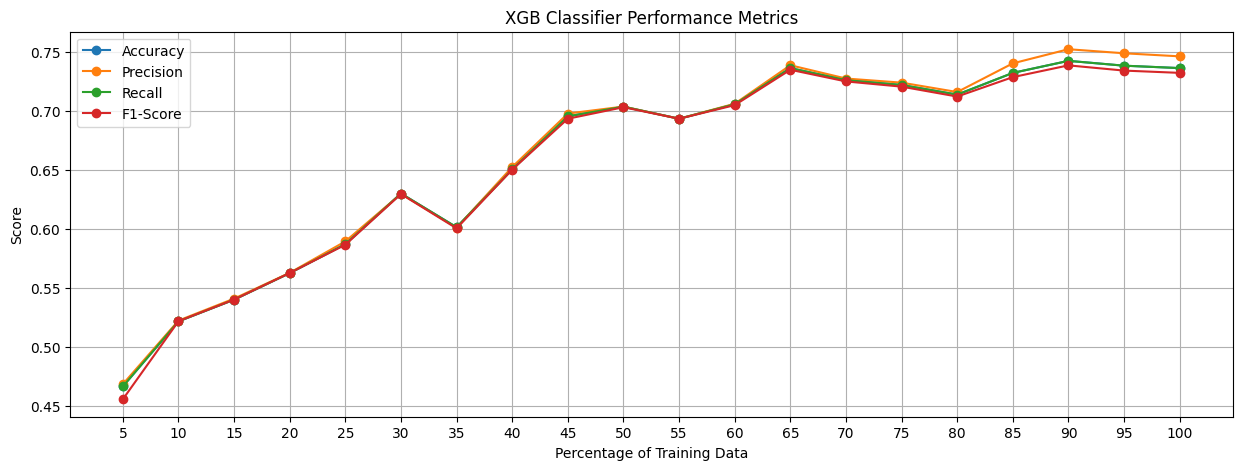

In [24]:
plot_results('XGB Classifier',xgb_result)

SVM Linear Classifer

In [25]:
svm_linear_model = SVC(kernel='linear', random_state=42)
svm_linear_result = train_validate_model(svm_linear_model, x_train, y_train)
print(svm_linear_result)

    Percentage of Training Data  Accuracy  Precision    Recall  F1-Score
0                             5  0.605317   0.609258  0.605317  0.604160
1                            10  0.660532   0.662171  0.660532  0.660455
2                            15  0.715746   0.716360  0.715746  0.715811
3                            20  0.738241   0.738323  0.738241  0.738270
4                            25  0.728016   0.728153  0.728016  0.728057
5                            30  0.756646   0.756643  0.756646  0.756489
6                            35  0.768916   0.769302  0.768916  0.768563
7                            40  0.781186   0.781218  0.781186  0.781199
8                            45  0.768916   0.768892  0.768916  0.768901
9                            50  0.815951   0.816250  0.815951  0.815758
10                           55  0.820041   0.820217  0.820041  0.820074
11                           60  0.828221   0.828221  0.828221  0.828221
12                           65  0.846626   0.84662

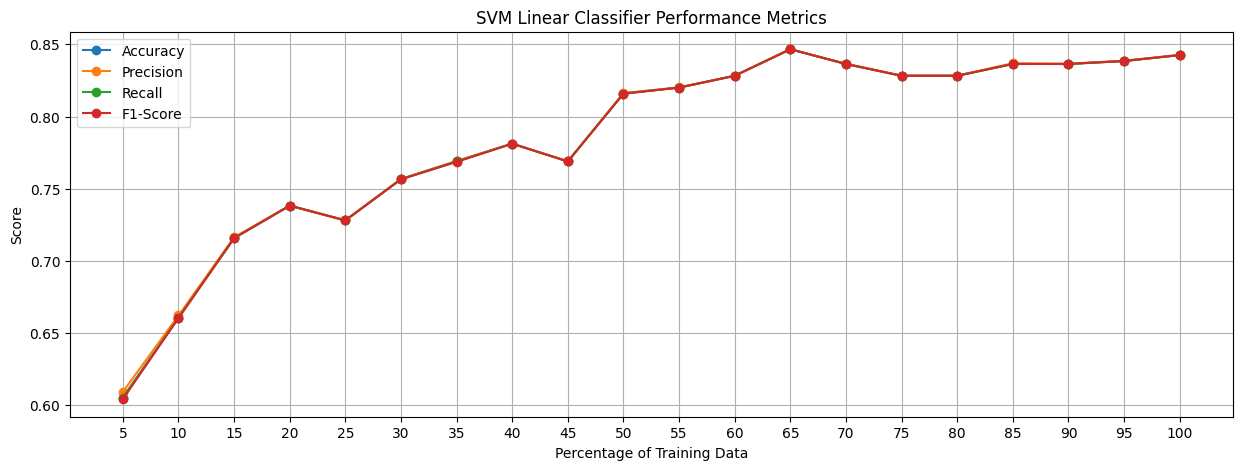

In [26]:
plot_results('SVM Linear Classifier',svm_linear_result)

SVM RBF Classifier

In [27]:
svm_rbf_model=SVC(kernel='rbf', random_state=42)
svm_rbf_result=train_validate_model(svm_rbf_model, x_train, y_train)
print(svm_rbf_result)

    Percentage of Training Data  Accuracy  Precision    Recall  F1-Score
0                             5  0.515337   0.538268  0.515337  0.470225
1                            10  0.521472   0.521594  0.521472  0.521524
2                            15  0.550102   0.549254  0.550102  0.548562
3                            20  0.556237   0.556078  0.556237  0.556137
4                            25  0.580777   0.581690  0.580777  0.580823
5                            30  0.601227   0.600854  0.601227  0.600474
6                            35  0.638037   0.637814  0.638037  0.637709
7                            40  0.650307   0.650382  0.650307  0.649357
8                            45  0.629857   0.629647  0.629857  0.629158
9                            50  0.660532   0.660362  0.660532  0.660270
10                           55  0.654397   0.654231  0.654397  0.653982
11                           60  0.672802   0.672793  0.672802  0.672244
12                           65  0.687117   0.68723

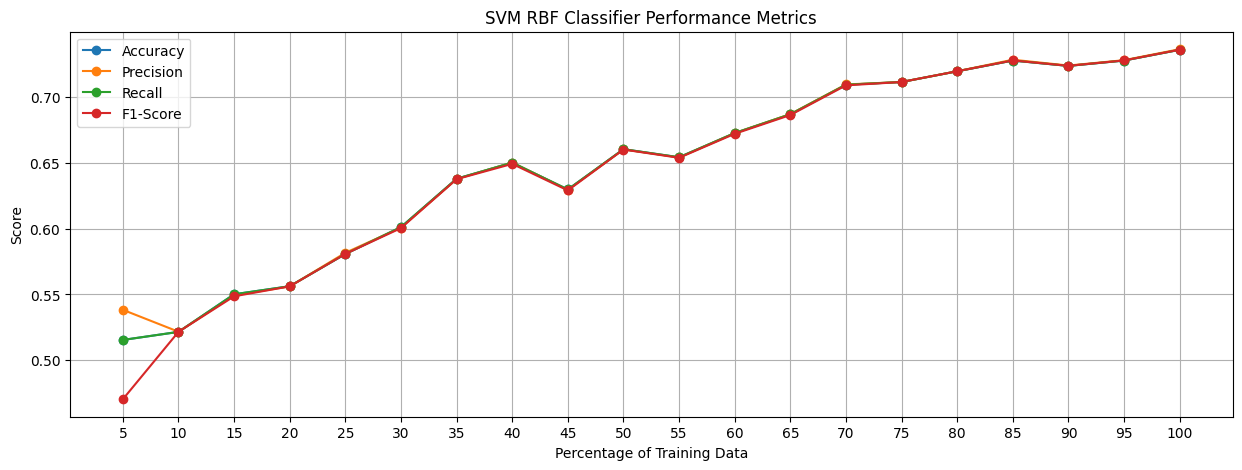

In [28]:
plot_results('SVM RBF Classifier',svm_rbf_result)

Naive Bayes Classifier

In [29]:
nb_model=GaussianNB()
nb_result=train_validate_model(nb_model, x_train, y_train)
print(nb_result)

    Percentage of Training Data  Accuracy  Precision    Recall  F1-Score
0                             5  0.631902   0.639117  0.631902  0.623440
1                            10  0.680982   0.708388  0.680982  0.673092
2                            15  0.687117   0.703816  0.687117  0.682819
3                            20  0.705521   0.719840  0.705521  0.702426
4                            25  0.719836   0.719895  0.719836  0.719500
5                            30  0.734151   0.734877  0.734151  0.734207
6                            35  0.723926   0.726313  0.723926  0.723781
7                            40  0.736196   0.739510  0.736196  0.735920
8                            45  0.732106   0.733802  0.732106  0.732068
9                            50  0.748466   0.748502  0.748466  0.748481
10                           55  0.746421   0.746761  0.746421  0.746479
11                           60  0.760736   0.761360  0.760736  0.760790
12                           65  0.764826   0.76525

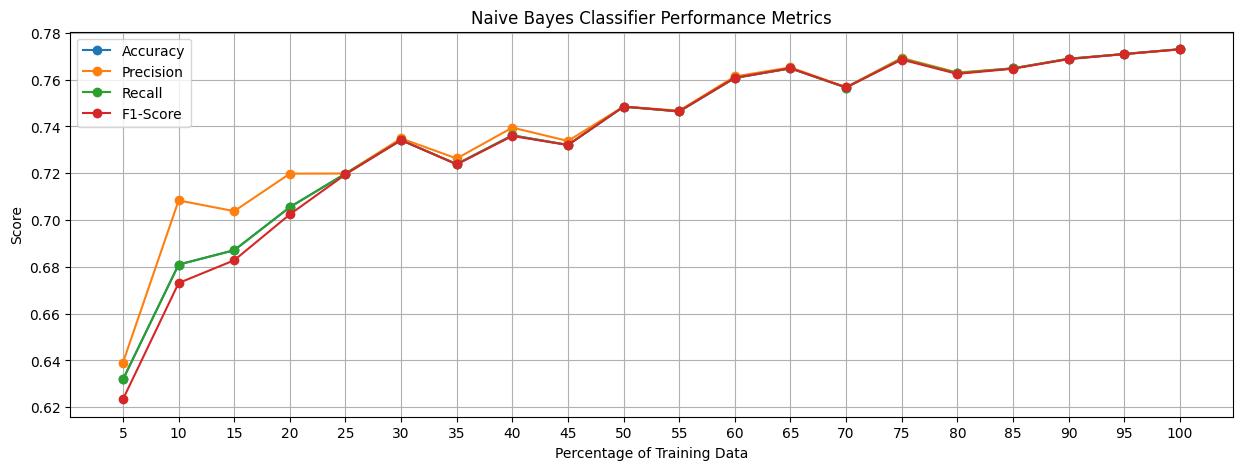

In [30]:
plot_results('Naive Bayes Classifier',nb_result)

Plotting Accuracies of all 7 models to different training data sizes

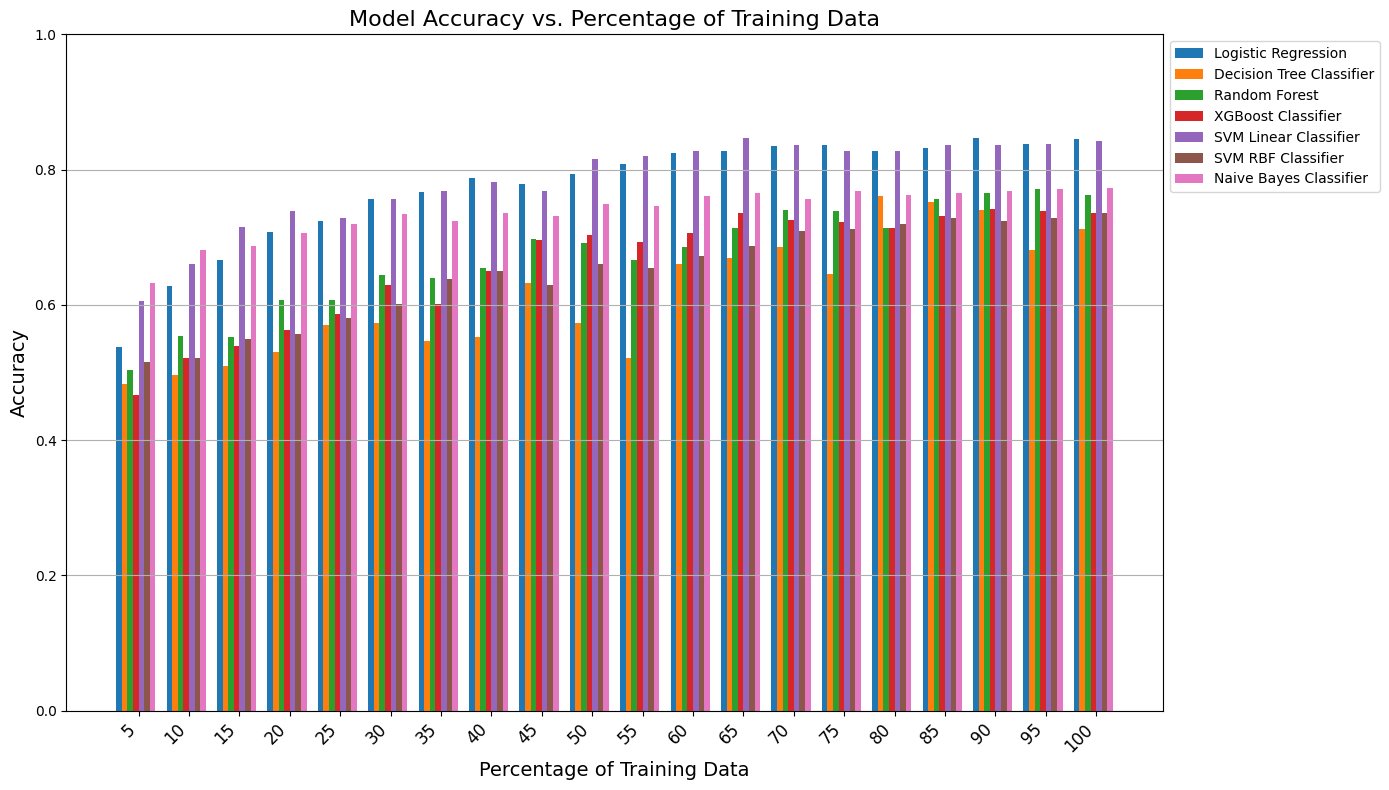

In [33]:
bar_width = 0.1 
num_bars = 8  

x = np.arange(len(lr_result['Percentage of Training Data'])) * (num_bars + 1) * bar_width

plt.figure(figsize=(14, 8))
plt.bar(x - bar_width * 3.5, lr_result['Accuracy'], width=bar_width, label='Logistic Regression')
plt.bar(x - bar_width * 2.5, dtc_result['Accuracy'], width=bar_width, label='Decision Tree Classifier')
plt.bar(x - bar_width * 1.5, rfc_result['Accuracy'], width=bar_width, label='Random Forest')
plt.bar(x - bar_width * 0.5, xgb_result['Accuracy'], width=bar_width, label='XGBoost Classifier')
plt.bar(x + bar_width * 0.5, svm_linear_result['Accuracy'], width=bar_width, label='SVM Linear Classifier')
plt.bar(x + bar_width * 1.5, svm_rbf_result['Accuracy'], width=bar_width, label='SVM RBF Classifier')
plt.bar(x + bar_width * 2.5, nb_result['Accuracy'], width=bar_width, label='Naive Bayes Classifier')

plt.title('Model Accuracy vs. Percentage of Training Data', fontsize=16)
plt.xlabel('Percentage of Training Data', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

plt.xticks(x, lr_result['Percentage of Training Data'], rotation=45, ha='right', fontsize=12)

plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [34]:

all_results = {
    'Logistic Regression': lr_result,
    'Decision Tree': dtc_result,
    'Random Forest': rfc_result,
    'XGBoost': xgb_result,
    'SVM Linear': svm_linear_result,
    'SVM RBF': svm_rbf_result,
    'Naive Bayes': nb_result,
}

combined_results = pd.concat(
    [df[['Percentage of Training Data', 'Accuracy']] for df in all_results.values()],
    keys=all_results.keys(), names=['Model', 'Index']).reset_index()

max_accuracy_row = combined_results.loc[combined_results['Accuracy'].idxmax()]

model_with_max_accuracy = max_accuracy_row['Model']
percentage_with_max_accuracy = max_accuracy_row['Percentage of Training Data']
max_accuracy = max_accuracy_row['Accuracy']

print(f"Model with the highest accuracy: {model_with_max_accuracy}")
print(f"Percentage of Training Data: {percentage_with_max_accuracy}%")
print(f"Highest accuracy: {max_accuracy:.4f}")


Model with the highest accuracy: Logistic Regression
Percentage of Training Data: 90%
Highest accuracy: 0.8466


Predicting labels for test data using Logistic Regression at 90% of training data.

In [35]:
x_train_split, _, y_train_split, _ = train_test_split(x_train, y_train, test_size=0.10, random_state=42)
lr_classifier = LogisticRegression()
lr_classifier.fit(x_train_split, y_train_split)
y_test_pred = lr_classifier.predict(x_test)
np.save("pred_emoticon.txt", y_test_pred)